In [137]:
%matplotlib inline
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("future-sales-data/sales_train.csv", parse_dates=['date'])
df_test = pd.read_csv("future-sales-data/testR.csv")
df_test_comp = pd.read_csv("future-sales-data/test.csv")
with open('shopItemSeriesR.json') as json_file:
    testData = json.load(json_file)
for k,v in testData.items():
    testData[k]=pd.Series(v)
with open('shopCatSeries.json') as json_file:
    testDataCat = json.load(json_file)
for k,v in testDataCat.items():
    testDataCat[k]=pd.Series(v[:-3])

In [139]:
# Create Clean Data

# df = pd.read_csv("future-sales-data/sales_train.csv", parse_dates=['date'])
# df_items = pd.read_csv("future-sales-data/items.csv")
# df['date'] = (df['date'].map(lambda d: d.replace(day=1)))
# df['date_block_num'] = (df['date'].map(lambda d: (d.year-2013)*12+d.month-1))
# df = df[df['date_block_num'] <= 33]
# df = df.groupby(['date', 'date_block_num', 'shop_id', 'item_id']).agg({"item_price": "mean", "item_cnt_day": "sum"}).reset_index()
# df.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)
# df = df.merge(df_items, on=["item_id"], how='inner')
# del df['item_name']
# df.to_csv('future-sales-data/sales_train.csv', index=False)

# testData = {}
# i=0
# for index, row in df_test.iterrows():
#     i+=1
#     if i%100 == 0:
#         print(i)
#     testData[str(row['shop_id'])+'_'+str(row['item_id'])] = getShopItemData(df, row['shop_id'], row['item_id'])['item_cnt_month'].tolist()
# json = json.dumps(testData)
# f = open("shopItemSeries.json","w")
# f.write(json)
# f.close()

# df_test['item_cnt_month'] = df_test.apply(lambda x: (testData[str(x['shop_id'])+'_'+str(x['item_id'])][-3]), axis=1)
# df_test.to_csv('future-sales-data/test.csv', index=False)

# nums = []
# for key, values in testData.items():
#     nums+=[(key, sum(i > .5 for i in values))]
# nums = list(map(lambda x: x[0], sorted(nums, reverse=True, key=lambda x: x[1])[:10]))
# testData2 = { your_key: testData[your_key].tolist() for your_key in nums }
# df_test2 = df_test[df_test.apply(lambda row: ((str(int(row['shop_id'])) + '_' + str(int(row['item_id']))) in nums), axis=1)]
# json = json.dumps(testData2)
# f = open("shopItemSeriesR.json","w")
# f.write(json)
# f.close()
# df_test2.to_csv('future-sales-data/testR.csv', index=False)

# testDataCat = {}
# df_items = pd.read_csv("future-sales-data/items.csv")
# i=0
# for index, row in df_test.iterrows():
#     i+=1
#     if i%100 == 0:
#         print(i)
#     testDataCat[str(int(row['shop_id']))+'_'+str(int(row['item_id']))] = getShopCatData(df, row['shop_id'], df_items[df_items['item_id']==row['item_id']]['item_category_id'].iloc[0])['item_cnt_month'].tolist()
# f = open("shopCatSeries.json","w")
# f.write(json.dumps(testDataCat))
# f.close()

100


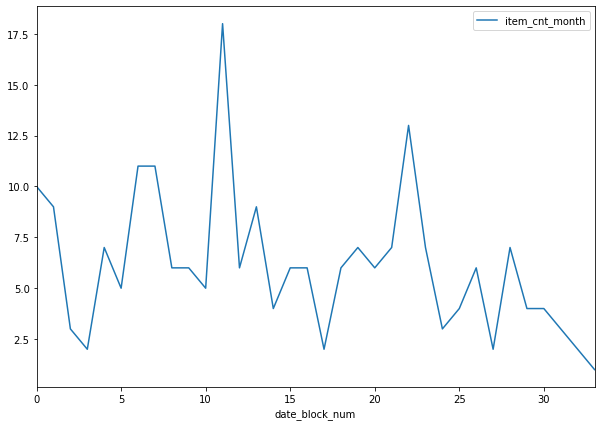

In [152]:
series = pd.date_range(start='2013-01-01', periods=34, freq='M').map(lambda d: d.replace(day=1))

def fillZeros(df, series):
    df = df.reindex(series)
    df['date_block_num'] = (df.index.map(lambda d: (d.year-2013)*12+d.month-1))
    if 'shop_id' in df:
        df['shop_id'] = df['shop_id'].fillna(method='ffill').fillna(method='bfill')
    if 'item_id' in df:
        df['item_id'] = df['item_id'].fillna(method='ffill').fillna(method='bfill')
    if 'item_category_id' in df:
        df['item_category_id'] = df['item_category_id'].fillna(method='ffill').fillna(method='bfill')
    if 'item_price' in df:
        df['item_price'] = df['item_price'].fillna(method='ffill').fillna(method='bfill')
#     df['item_cnt_month'] = df['item_cnt_month'].fillna(0)
    df = df.fillna(0)
    return df

def getShopItemData(df, shopId, itemId):
    ans = df.loc[(df['shop_id'] == shopId) & (df['item_id'] == itemId)].set_index('date')
    return fillZeros(ans, series)

def getItemData(df, itemId):
    df_item = df.groupby(['date', 'date_block_num', 'item_id', 'item_category_id']).agg({"item_price": "mean", "item_cnt_month": "sum"}).reset_index()
    ans = df_item.loc[(df_item['item_id'] == itemId)].set_index('date')
    return fillZeros(ans, series)

def getShopData(df, shopId):
    df_shop = df.groupby(['date', 'date_block_num', 'shop_id']).agg({"item_cnt_month": "sum"}).reset_index()
    ans = df_shop.loc[(df_shop['shop_id'] == shopId)].set_index('date')
    return fillZeros(ans, series)

def getShopCatData(df, shopId, catId):
    df_shop_cat = df.groupby(['date', 'date_block_num', 'shop_id', 'item_category_id']).agg({"item_cnt_month": "sum"}).reset_index()
    ans = df_shop_cat.loc[(df_shop_cat['shop_id'] == shopId) & (df_shop_cat['item_category_id'] == catId)].set_index('date')
    return fillZeros(ans, series)

def getCatData(df, catId):
    df_cat = df.groupby(['date', 'date_block_num', 'item_category_id']).agg({"item_cnt_month": "sum"}).reset_index()
    ans = df_cat.loc[(df_cat['item_category_id'] == catId)].set_index('date')
    return fillZeros(ans, series)

def getData(df):
    df = df.groupby(['date', 'date_block_num']).agg({"item_cnt_month": "sum"}).reset_index()
    ans = df.set_index('date')
    return fillZeros(ans, series)

def plotData(df, ax = None):
    figsize=(10,7)
    if len(df)>1:
        if ax is None:
            return df.plot(x='date_block_num', y='item_cnt_month', figsize=figsize)
        else:
            df.plot(x='date_block_num', y='item_cnt_month', ax=ax, figsize=figsize)
    return ax
    
testDataPrice = {}
i=0
for index, row in df_test.iterrows():
    i+=1
    if i%100 == 0:
        print(i)
    testDataPrice[str(int(row['shop_id']))+'_'+str(int(row['item_id']))] = getShopItemData(df, row['shop_id'], row['item_id'])['item_price']
    
plotData(getShopItemData(df, 31, 6185))
# getItemData(df, 0)

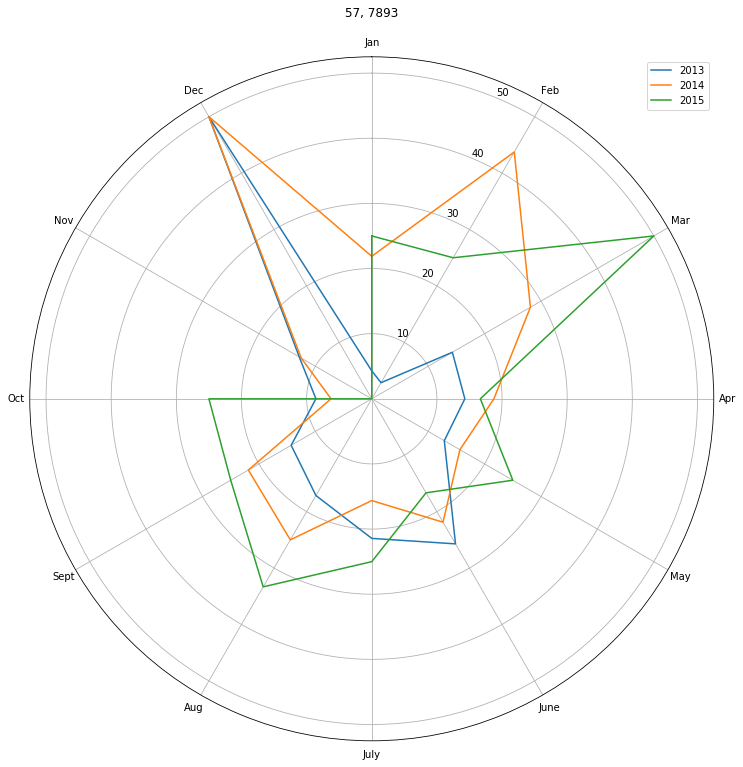

In [15]:
def getYearData(df, year):
    data = df.loc[(df['date_block_num']>=(year-1)*12) & (df['date_block_num']<year*12)]
    data['date_block_num'] = data['date_block_num'] - (year-1)*12 + 1
    return data

def plotSeasonalData(df):
    ax = None
    ax = plotData(getYearData(df, 1), ax)
    ax = plotData(getYearData(df, 2), ax)
    ax = plotData(getYearData(df, 3), ax)
    ax.legend(['2013', '2014', '2015'])
    ax.set_xlabel('month')
    return ax

def plotPolarSeasonalData(df):
    fig = plt.figure(figsize=(10, 10))
    rect = [0.05, 0.05, 0.95, 0.95]
    ax = fig.add_axes(rect, projection="polar")
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location("N")
    angles = [a for a in np.arange(0, 360, 360.0/12)]
    labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
    ax.set_thetagrids(angles, labels=labels)
    values = getYearData(df, 1)['item_cnt_month']
    ax.plot(np.deg2rad(np.r_[angles, angles[0]]), np.r_[values, values[0]]/max(values)*50)
    values = getYearData(df, 2)['item_cnt_month']
    ax.plot(np.deg2rad(np.r_[angles, angles[0]]), np.r_[values, values[0]]/max(values)*50)
    values = getYearData(df, 3)['item_cnt_month']
    ax.plot(np.deg2rad(np.r_[angles, angles[0]]), np.r_[values, values[0]]/max(values)*50)
    return ax
    

# for index, row in df.groupby(['date', 'shop_id', 'item_id']).agg({"date_block_num": "count"}).reset_index().groupby(['shop_id', 'item_id']).count().reset_index().sort_values(by=['date']).tail(50).iterrows():
#     ax = plotSeasonalData(getShopItemData(df, row['shop_id'],row['item_id']))
#     ax.set_title(str(row['shop_id'])+', ' +str(row['item_id']))

# ax = plotData(getShopItemData(df, 57,7893))
# ax.legend([])
# ax.set_title(str(57)+', ' +str(7893))
# ax.set_xlabel('date_block_num')

ax = plotPolarSeasonalData(getShopItemData(df, 57, 7893))
ax.set_title(str(57)+', ' +str(7893))
ax.legend(['2013', '2014', '2015'])

In [140]:
def getRMSE(pred, test):
    return ((pred.round() - test['item_cnt_month']) ** 2).mean() ** .5

def testModel(model, isSeries=True):
    if isSeries:
        func = lambda x: model(testData[str(int(x['shop_id']))+'_'+str(int(x['item_id']))])
    else:
        func = lambda x: model(testData[str(int(x['shop_id']))+'_'+str(int(x['item_id']))], testDataCat[str(int(x['shop_id']))+'_'+str(int(x['item_id']))], testDataPrice[str(int(x['shop_id']))+'_'+str(int(x['item_id']))][:-1].reset_index(drop=True))
    res = df_test2.apply(func, axis=1)
    return getRMSE(res, df_test)

In [138]:
def NaiveModel(arr):
    return arr[32]

testModel(NaiveModel)

204.71130892063584

In [26]:
def SNaiveModel(arr):
    return arr[21]

testModel(SNaiveModel)

222.65338533244895

In [28]:
from statsmodels.tsa.api import SimpleExpSmoothing

def SimpleExpSmoothingModel(arr):
    return SimpleExpSmoothing(arr).fit(smoothing_level=0.2,optimized=False).forecast(1).iloc[0]

testModel(SimpleExpSmoothingModel)

204.5108065604358

In [29]:
from statsmodels.tsa.api import Holt

def HoltModel(arr):
    return Holt(arr).fit(smoothing_level=.3, smoothing_slope=.05).forecast(1).iloc[0]

testModel(HoltModel)

202.13290182451743

In [189]:
from statsmodels.tsa.api import Holt

def HoltModel(arr):
    return Holt(arr).fit(smoothing_level=.17, smoothing_slope=.007).forecast(1).iloc[0]

testModel(HoltModel)

200.96128898370492

In [191]:
from statsmodels.tsa.api import Holt
from statsmodels.tsa.seasonal import seasonal_decompose

def HoltModel(arr):
    decompose = seasonal_decompose(arr, model='additive', extrapolate_trend='freq', freq=12)
    return Holt(decompose.trend).fit(smoothing_level=.17, smoothing_slope=.007).forecast(1).iloc[0]+decompose.seasonal[21]

# print(HoltModel(pd.Series(list(range(33)))))
testModel(HoltModel)

207.24330484784255

In [192]:
from statsmodels.tsa.arima_model import ARIMA

def ARIMAModel(arr):
    return ARIMA(arr.astype(float), order=(0,1,0)).fit(disp=0).forecast(1)[0][0]

# print(ARIMAModel(pd.Series(list(range(33)))))
testModel(ARIMAModel)

204.15626145619862

In [193]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def SARIMAXModel(arr):
    return SARIMAX(arr, order=(0, 0, 1),seasonal_order=(1, 1, 1, 8),enforce_stationarity=False,enforce_invertibility=False).fit().forecast(1).iloc[0]

# print(SARIMAXModel(pd.Series(list(range(33)))))
testModel(SARIMAXModel)

213.84574222647888

In [194]:
testModel(lambda x: 0.5)

229.75241021586695

In [195]:
def create_dataset(dataset):
    X = pd.concat([dataset.shift(3)[3:], dataset.shift(2)[3:], dataset.shift(1)[3:], pd.concat([dataset[3:12], dataset.shift(12)[12:]])], axis=1)
    y = dataset[3:]
    test = np.array([dataset.tolist()[-3:]+[dataset[len(dataset)-11]]])
    return X, y, test

# def create_dataset(dataset):
#     X = pd.concat([dataset.shift(1)[1:]], axis=1)
#     y = dataset[1:]
#     test = np.array([dataset.tolist()[-1:]])
#     return X, y, test

In [106]:
def create_dataset(shopItem, itemCat, itemPrice):
    X = pd.concat([shopItem.shift(3)[3:], shopItem.shift(2)[3:], shopItem.shift(1)[3:], pd.concat([shopItem[3:12], shopItem.shift(12)[12:]]), 
                   itemCat.shift(3)[3:], itemCat.shift(2)[3:], itemCat.shift(1)[3:], pd.concat([itemCat[3:12], itemCat.shift(12)[12:]]), 
                   itemPrice[3:]], axis=1)
    y = shopItem[3:]
    test = np.array([shopItem.tolist()[-3:]+[shopItem[len(shopItem)-11]] + itemCat.tolist()[-3:]+[itemCat[len(itemCat)-11]] + [itemPrice[len(itemPrice)-1]]])
    return X, y, test

In [107]:
from sklearn.linear_model import LinearRegression

def LinearModel(arr, ar, a):
    X, y, test = create_dataset(arr, ar, a)
    model=LinearRegression()
    model.fit(X,y)
    return model.predict(test)[0]

# print(LinearModel(pd.Series(list(range(33)))))
testModel(LinearModel, isSeries=False)

154.18368915031186

In [110]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

def LinearModel(arr, ar, a):
    decompose = seasonal_decompose(arr, model='additive', extrapolate_trend='freq', freq=12)
    X, y, test = create_dataset(decompose.trend, ar, a)
    model=LinearRegression()
    model.fit(X,y)
    return model.predict(test)[0] + decompose.seasonal[21]

# print(LinearModel(pd.Series(list(range(33)))))
testModel(LinearModel, isSeries=False)

204.47642895942798

In [119]:
from sklearn.preprocessing import PolynomialFeatures

def PolynomialModel(arr, ar, a):
    X, y, test = create_dataset(arr, ar, a)
    poly_reg = PolynomialFeatures(degree=3)
    X_poly = poly_reg.fit_transform(X)
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    return pol_reg.predict(poly_reg.transform(test))[0]

# print(PolynomialModel(pd.Series(list(range(33)))))
testModel(PolynomialModel, isSeries=False)

250.60159616411067

In [136]:
from sklearn.neural_network import MLPRegressor

def MLPModel(arr, ar, a):
    X, y, test = create_dataset(arr, ar, a)
    return MLPRegressor(hidden_layer_sizes=(300,), solver='lbfgs').fit(X,y).predict(test)[0]

# print(MLPModel(pd.Series(list(range(33)))))
testModel(MLPModel, isSeries=False)

136.14084618511816

In [141]:
from sklearn.neural_network import MLPRegressor

def MLPModel(arr, ar, a):
    X, y, test = create_dataset(arr, ar, a)
    return MLPRegressor(hidden_layer_sizes=(300,), solver='lbfgs').fit(X,y).predict(test)[0]

# print(MLPModel(pd.Series(list(range(33)))))
testModel(MLPModel, isSeries=False)

18.793615937333612

In [144]:
import math
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.layers import LSTM, Dropout, Activation

def LSTMModel(arr, ar, a):
    arr = arr.astype('float32')
    X, y, test = create_dataset(arr, ar, a)
    X = np.array(X).reshape((X.shape[0], X.shape[1], 1))
    test = np.reshape(test, (test.shape[0], test.shape[1], 1))
    model = Sequential()
    model.add(LSTM(input_shape=(9, X.shape[2]), return_sequences=True, units=10))
    model.add(Dropout(0.5))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(LeakyReLU(alpha=0.6))
    model.add(Activation('linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X, y, epochs=10, batch_size=1, verbose=1)
    return model.predict(test)[0][0]

# print(LSTMModel(pd.Series(list(range(33)))))
testModel(LSTMModel, isSeries=False)

Epoch 1/10
30/30 [==============================] - 1s 17ms/step - loss: 5352.5127
Epoch 2/10
30/30 [==============================] - 0s 5ms/step - loss: 3664.8982
Epoch 3/10
30/30 [==============================] - 0s 5ms/step - loss: 3146.8557
Epoch 4/10
30/30 [==============================] - 0s 5ms/step - loss: 2861.6135
Epoch 5/10
30/30 [==============================] - 0s 5ms/step - loss: 2610.5786
Epoch 6/10
30/30 [==============================] - 0s 5ms/step - loss: 2302.0628
Epoch 7/10
30/30 [==============================] - 0s 5ms/step - loss: 2271.8983
Epoch 8/10
30/30 [==============================] - 0s 5ms/step - loss: 2134.2413
Epoch 9/10
30/30 [==============================] - 0s 5ms/step - loss: 2052.1276
Epoch 10/10
30/30 [==============================] - 0s 5ms/step - loss: 1990.1474
Epoch 1/10
30/30 [==============================] - 1s 18ms/step - loss: 239.4892
Epoch 2/10
30/30 [==============================] - 0s 5ms/step - loss: 128.8830
Epoch 3/10
30/3

7.3824115301167

In [ ]:
from sklearn.neural_network import MLPRegressor

def MLPModel(arr, ar, a):
    X, y, test = create_dataset(arr, ar, a)
    return MLPRegressor(hidden_layer_sizes=(300,), solver='lbfgs').fit(X,y).predict(test)[0]

func = lambda row: MLPModel(getShopItemData(df, row['shop_id'], row['item_id'])['item_cnt_month'].reset_index(drop=True), getShopCatData(df, row['shop_id'], df_items[df_items['item_id']==row['item_id']]['item_category_id'].iloc[0])['item_cnt_month'].reset_index(drop=True), getShopItemData(df, row['shop_id'], row['item_id'])['item_price'].reset_index(drop=True))
res = df_test_comp.apply(func, axis=1)